# LLM Tooling with Agents

## **Goal**
Our goal in this notebook is to build and use LLM agents which can work together, they can have different roles, and also they have different tools which extends their performance in the case of tasks which are better solved with classic algortihms or needs extra information from an API for example

## **Content**

- One Simple architecture wrote from scracth using only one "Tooling" Agent, which can plan how to solve the user's requests, call the tools and answer the user. This solution simple tools, more focus is on tooling agent and the communication.

- Second example is a little bit more complex, it uses **Autogen** framework from Microsoft. It has more meaningful tools, including API calls, and one Text2Image model.

## **Important**
The models are the same as in the Knowledge Graph Example Notebook, also making the OpenAI API account how to insert API Key into Colab Secret, and how read from there can be found in that notebook.



## Download all necessary packages

In [ ]:
!pip install openai==1.52.2 -q
!pip install llama-index==0.11.19 -q
!pip install llama-index-llms-openai==0.2.16 -q
!pip install OSMPythonTools==0.3.5 -q
!pip install autogen==0.3.1 -q
!pip install autogen-agentchat==0.2.37 -q
!pip install transformers==4.46.0 -q
!pip install accelerate==1.0.1 -q
!pip install diffusers==0.31.0 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.8/176.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.8/295.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.1/350.1 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.9/313.9 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━

In [ ]:
from google.colab import userdata
api_key = userdata.get('OPEN_AI_KEY')

## Import every package used in this notebook

# 1. Example

### Simple LLM Agent from scratch using OpenAI models.

Tools used:
- **Pythagorean theorem tool:** Calculates the pyhtagorean of the two input numbers
- **Square Tool:** Calculates the square of a given number
- **Add numbers tool:** Caluclates the addition of two given numbers

Additional tools can be added.

Architecture:
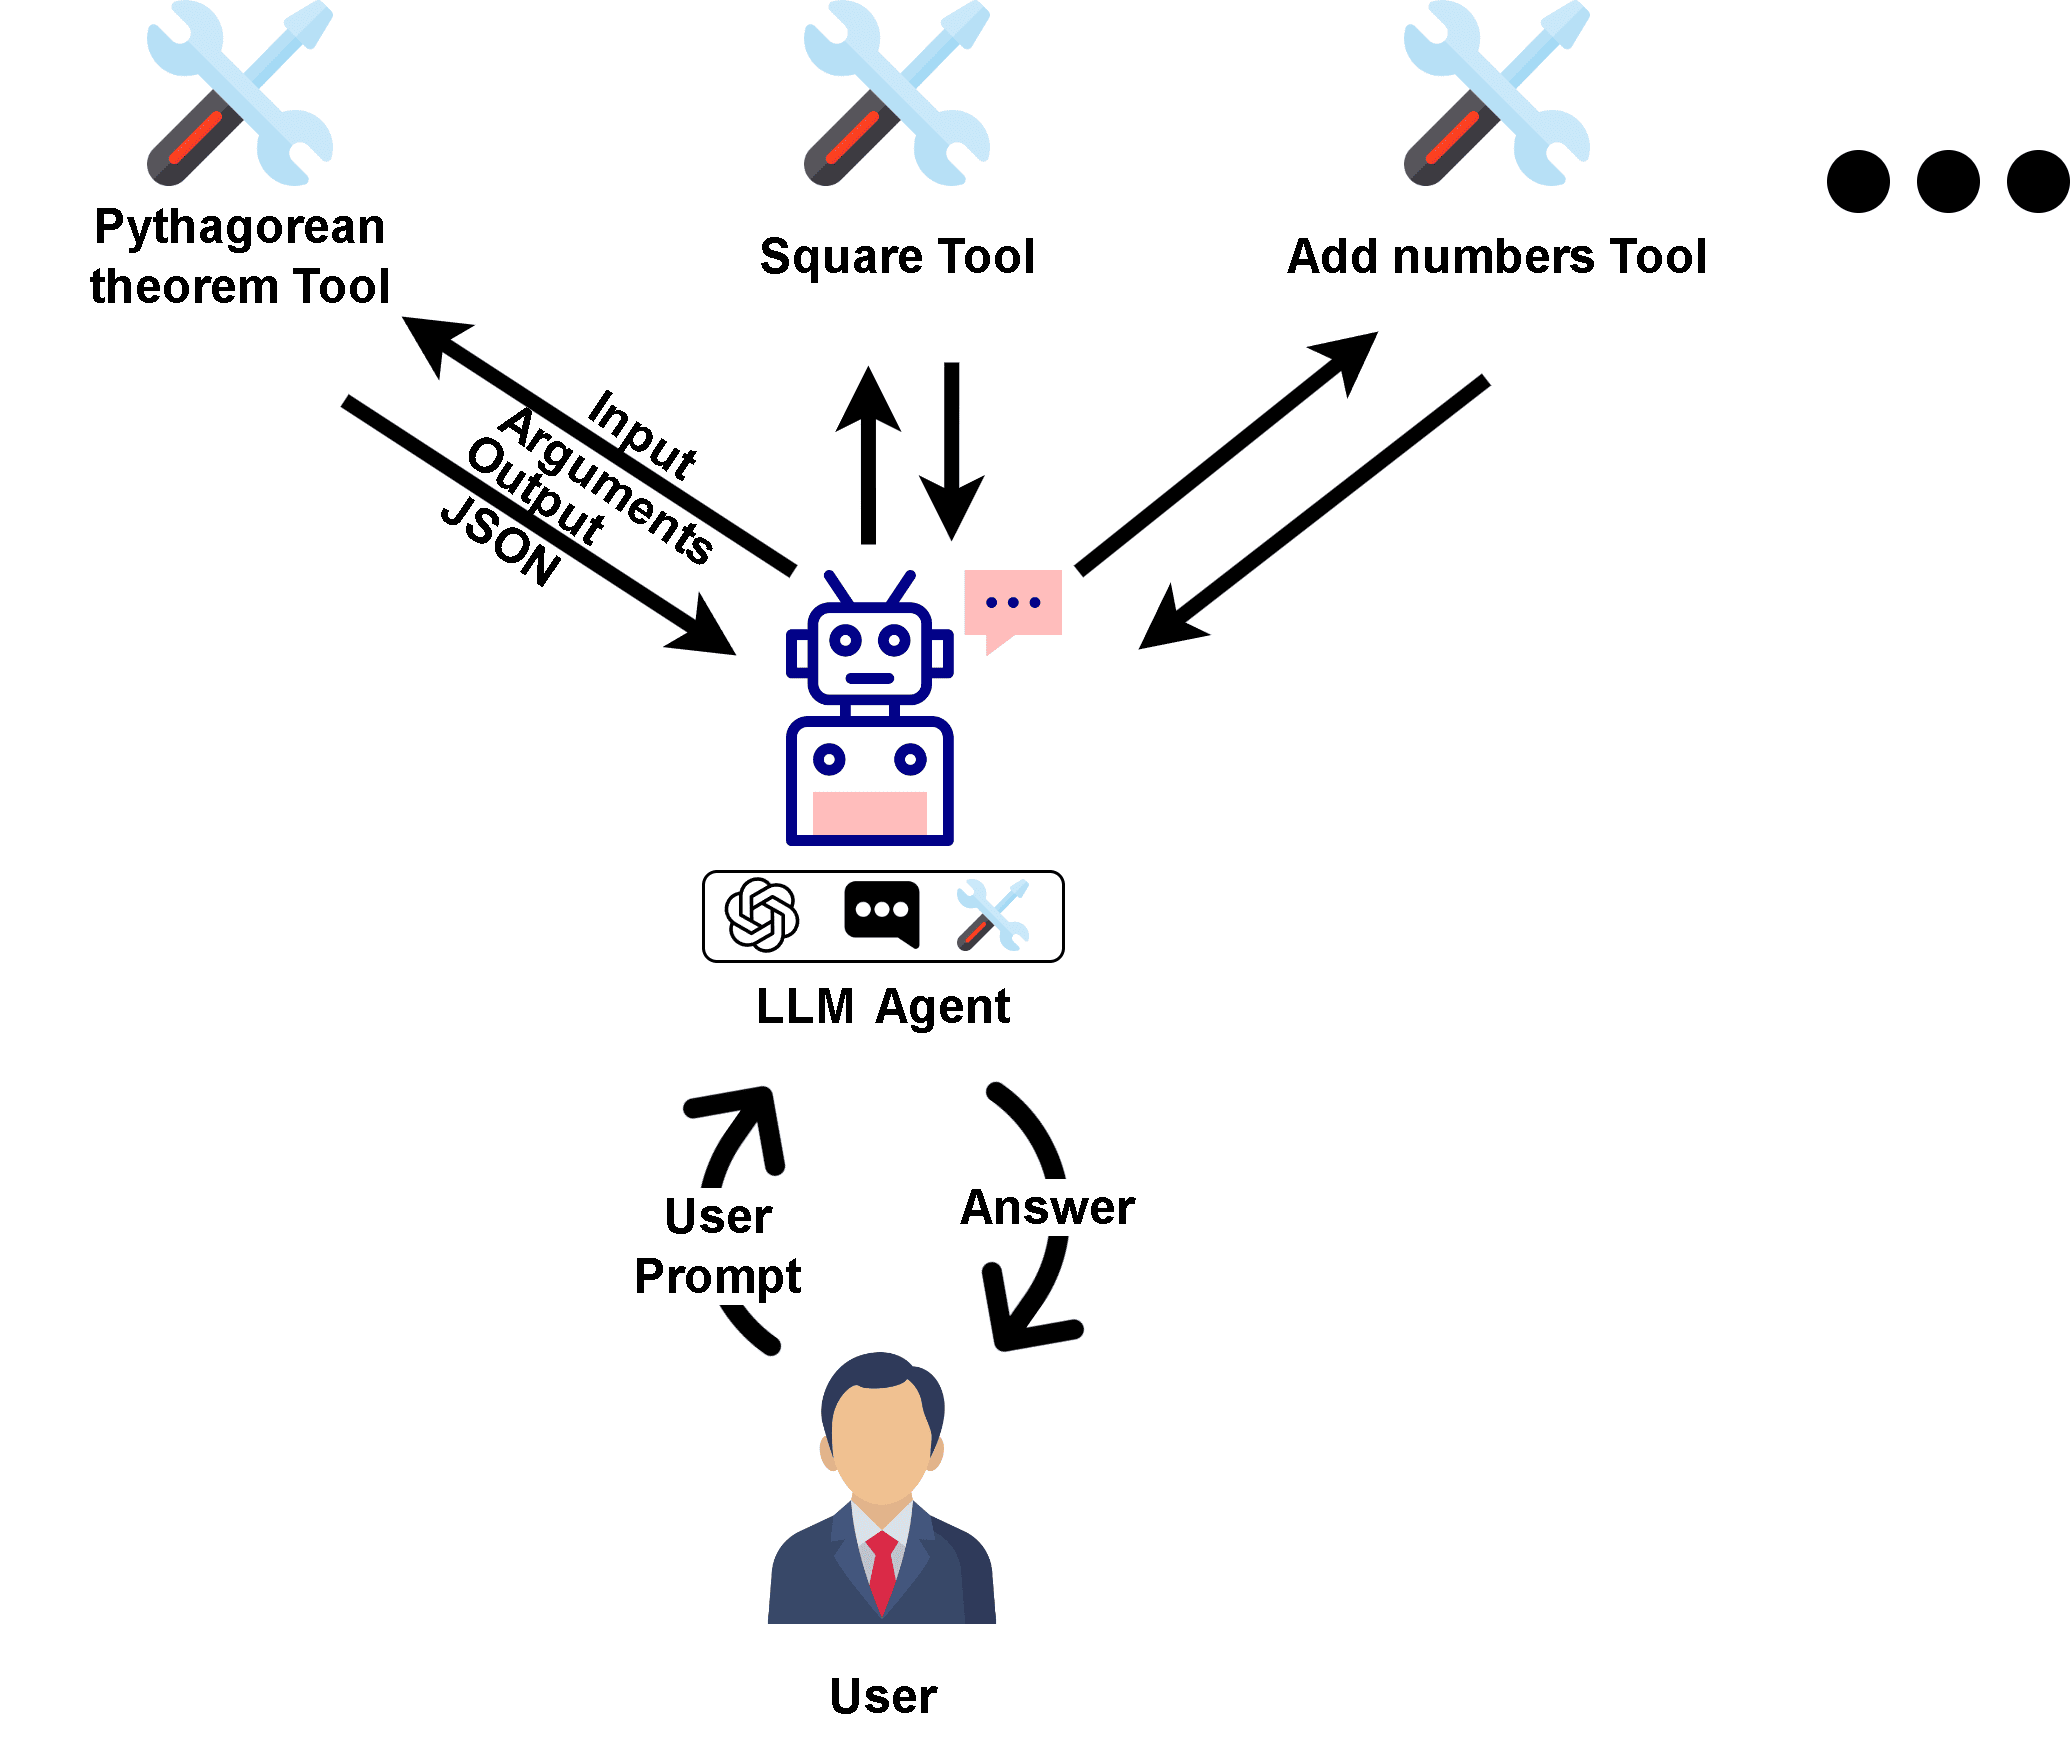

In [ ]:
# from openai import OpenAI
from llama_index.core.prompts import ChatMessage, PromptTemplate, ChatPromptTemplate
from textblob import TextBlob
from llama_index.llms.openai import OpenAI
from llama_index.core.memory import ChatMemoryBuffer
import tiktoken
import json
import os
from OSMPythonTools.nominatim import Nominatim
import requests
import random
from autogen import ConversableAgent, register_function, GroupChat, UserProxyAgent, GroupChatManager
import torch
from diffusers import AutoPipelineForText2Image
from diffusers.pipelines.wuerstchen import DEFAULT_STAGE_C_TIMESTEPS
from IPython.display import display
from datetime import datetime
from PIL import Image

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

## Code Structure and Workflow

### Overview
This notebook demonstrates the creation and usage of LLM agents with different roles and tools. The agents can solve user queries by leveraging various tools, such as mathematical operations, weather information retrieval, dad joke retrieval, and text-to-image generation.

### Key Components
1. **Tooling Agent**: This agent is responsible for interpreting user queries, reasoning about the necessary actions, planning the steps, and executing the required tools. The agent loop is implemented using a JSON-based schema to ensure structured communication between the agent and the tools.

2. **Autogen Framework**: The second example uses the Autogen framework from Microsoft to create a more complex agent system. This includes multiple agents with specific roles, such as a planner, tool agent, and user proxy agent, which work together to solve user queries.

### Agent Loop
The agent loop is implemented using a JSON-based schema, which includes the following steps:
- **Observation**: Interpreting the user or tool inputs.
- **Reasoning**: Explaining the next action to achieve the original goal.
- **Plan**: Determining which tools to use and how to parameterize them.
- **Critique**: Improving the reasoning and plan.
- **Action**: The exact tool call as a JSON object.

### JSON Schema
While the current implementation uses objects to represent the agent's actions and responses, a JSON schema could also be specified to ensure a more structured and standardized communication format. This would involve defining a JSON schema for each type of message exchanged between the agents and tools, ensuring consistency and validation of the data.

Example JSON Schema:
```json
{
    "type": "object",
    "properties": {
        "observation": {
            "type": "string",
            "description": "Interpreting the user or tool inputs"
        },
        "reasoning": {
            "type": "string",
            "description": "Explaining the next action to achieve the original goal"
        },
        "plan": {
            "type": "string",
            "description": "Determining which tools to use and how to parameterize them"
        },
        "critique": {
            "type": "string",
            "description": "Improving the reasoning and plan"
        },
        "action": {
            "type": "object",
            "properties": {
                "name": {
                    "type": "string",
                    "description": "The name of the tool to call"
                },
                "arguments": {
                    "type": "object",
                    "description": "The arguments required by the tool"
                }
            },
            "required": ["name", "arguments"]
        }
    },
    "required": ["observation", "reasoning", "plan", "critique", "action"]
}
```

In [ ]:
os.environ['OPENAI_API_KEY'] = api_key
OPENAI_CHAT_MODEL_NAME="gpt-4o-mini"

In [ ]:
llm = OpenAI(model=OPENAI_CHAT_MODEL_NAME, temperature=0.3)
tokenizer = tiktoken.encoding_for_model(OPENAI_CHAT_MODEL_NAME).encode

In [ ]:
system_prompt = f"""
  You are an autonomous agent who has to solve problems the user provides.
  Use only the tools to answer the questions. If you are unsure about how to
  solve the problem, ask the user additional question or clarification.
  Always call one action at a time.
  You always answer as a JSON performing the following steps and stages:
  {{
    'observation': 'Interpreting the user or tool inputs',
    'reasoning': 'Explain what is your next action to achieve the original goal',
    'plan': 'Come up with a plan determining which tools to use and how to parameterize it',
    'critique':'Improve the reasoning and plan',
    'action': 'The exact tool call as a JSON object'
  }}

  Answer with the JSON only keeping the order of the steps as outlined above.

  Available tools:
  [
    {{
      'name': 'number_square',
      'description': 'Returns the square of a number',
      'arguments':
        {{
          'number': 'a valid number which can be squared'
        }}
    }},
    {{
       'name': 'pythagorean_theorem',
       'description': 'Returns the hypotenuse of a right triangle',
       'arguments':
        {{
          'a':'The first number',
          'b':'The second number',
        }}
    }},
    {{
        'name': 'add_two_numbers',
        'description': 'Makes the addition of two numbers given as parameters',
        'arguments':
        {{
          'a': 'First Number',
          'b': 'Second Number'
        }}
    }},
    {{
       'name': 'answer_user',
       'arguments':
        {{
          'answer':'The answer to send to the user'
        }}
    }}
  ]

  Example tool call:
  {{
    'name':'answer_user',
    'arguments':
      {{
        'answer':'Hello there my lord!'
      }}
  }}
"""

In [ ]:
agent_template = ChatPromptTemplate(message_templates=[ChatMessage(role="system", content=system_prompt)])

In [ ]:
def pythagorean_theorem(args):
  return (args['a']**2 + args['b']**2)**0.5

def square(args):
  return args['number']**2

def add_two_numbers(args):
    return args['a'] + args['b']

In [ ]:
tool_library = {
    'number_square': square,
    'pythagorean_theorem': pythagorean_theorem,
    'add_two_numbers': add_two_numbers
}

In [ ]:
class Agent:
    def __init__(self, tools):
        self.tools = tools
        self.base_message = agent_template.format_messages()

        self.chat_history = ChatMemoryBuffer.from_defaults(self.base_message,
                            llm=llm,
                            tokenizer_fn=tokenizer,token_limit=32000)


    def reset_history(self):
        self.memory.reset()

    def query_model(self, user_input):
        self.chat_history.put(ChatMessage(role="user", content=f"{user_input}"))

        history_dict = self.chat_history.get_all()
        resp = llm.chat(
              model="gpt-4o-mini",
              messages=history_dict,
              temperature=0.0,
              response_format={ "type": "json_object" }
          )
        resp_json = json.loads(resp.message.content)
        self.chat_history.put(ChatMessage(role="assistant", content=json.dumps(resp_json)))

        return resp_json

    def run(self, user_input):
        resp_json = self.query_model(user_input)
        while True:
          print(f"\n\nAgent: \nPlan: {resp_json['plan']}\n\n")
          print(f"\n\nAgent: \nReasoning: {resp_json['reasoning']}\n\n")
          # print(resp_json)
          if resp_json['action'] is None or resp_json['action']['name'] == 'answer_user':
            return resp_json['action']['arguments']['answer']
          else:
            tool_json = self.take_action(resp_json['action'])
            resp_json = self.query_model(tool_json)

    def take_action(self, action):
        result = {}
        result['tool'] = action['name']
        result['message'] = "tool response"
        try:
          if action['name'] in self.tools:
              tool_result = self.tools[action['name']](action['arguments'])
              result['status'] = "success"
              result['description'] = tool_result
          else:
              result['status'] = "error"
              result['description'] = "Tool not found"
        except Exception as e:
          result['status'] = "error"
          result['description'] = str(e)
        return result


In [ ]:
agent = Agent(tool_library)

# Trying out our Simple Agent, you can finish the conversation with ***quit*** or ***exit*** words

In [ ]:
def interactive_agent():
    print("Welcome to the LLM Tooling Agent!")
    while True:
        user_input = input("Your question: ")
        if user_input.lower() in ['exit', 'quit']:
            print("Goodbye!")
            break
        response = agent.run(user_input)
        print(f"\n\nAgent: {response}\n\n")

interactive_agent()



Welcome to the LLM Tooling Agent!
Your question: exit
Goodbye!


# 2.Example

### Building LLM agents using [**Autogen**](https://microsoft.github.io/autogen/0.2/docs/Getting-Started) from Microsoft

#### Tools used
- **Weather API tool:** For a given city, gives back weather information using [OpenStreetMap](https://nominatim.org/) and [Open Meteo API](https://open-meteo.com/)
- **Dad Joke Retrieval Tool:** Either gives back a random dad joke or gives back a dad joke based on a search term using the following API [icanhazdadjoke](https://icanhazdadjoke.com/api)
- **Text2Image Generation Tool:** using the [Würstchen model](https://huggingface.co/warp-ai/wuerstchen) which fits into the Colab free tier GPU, and generates an image from a given text.

Architecture:
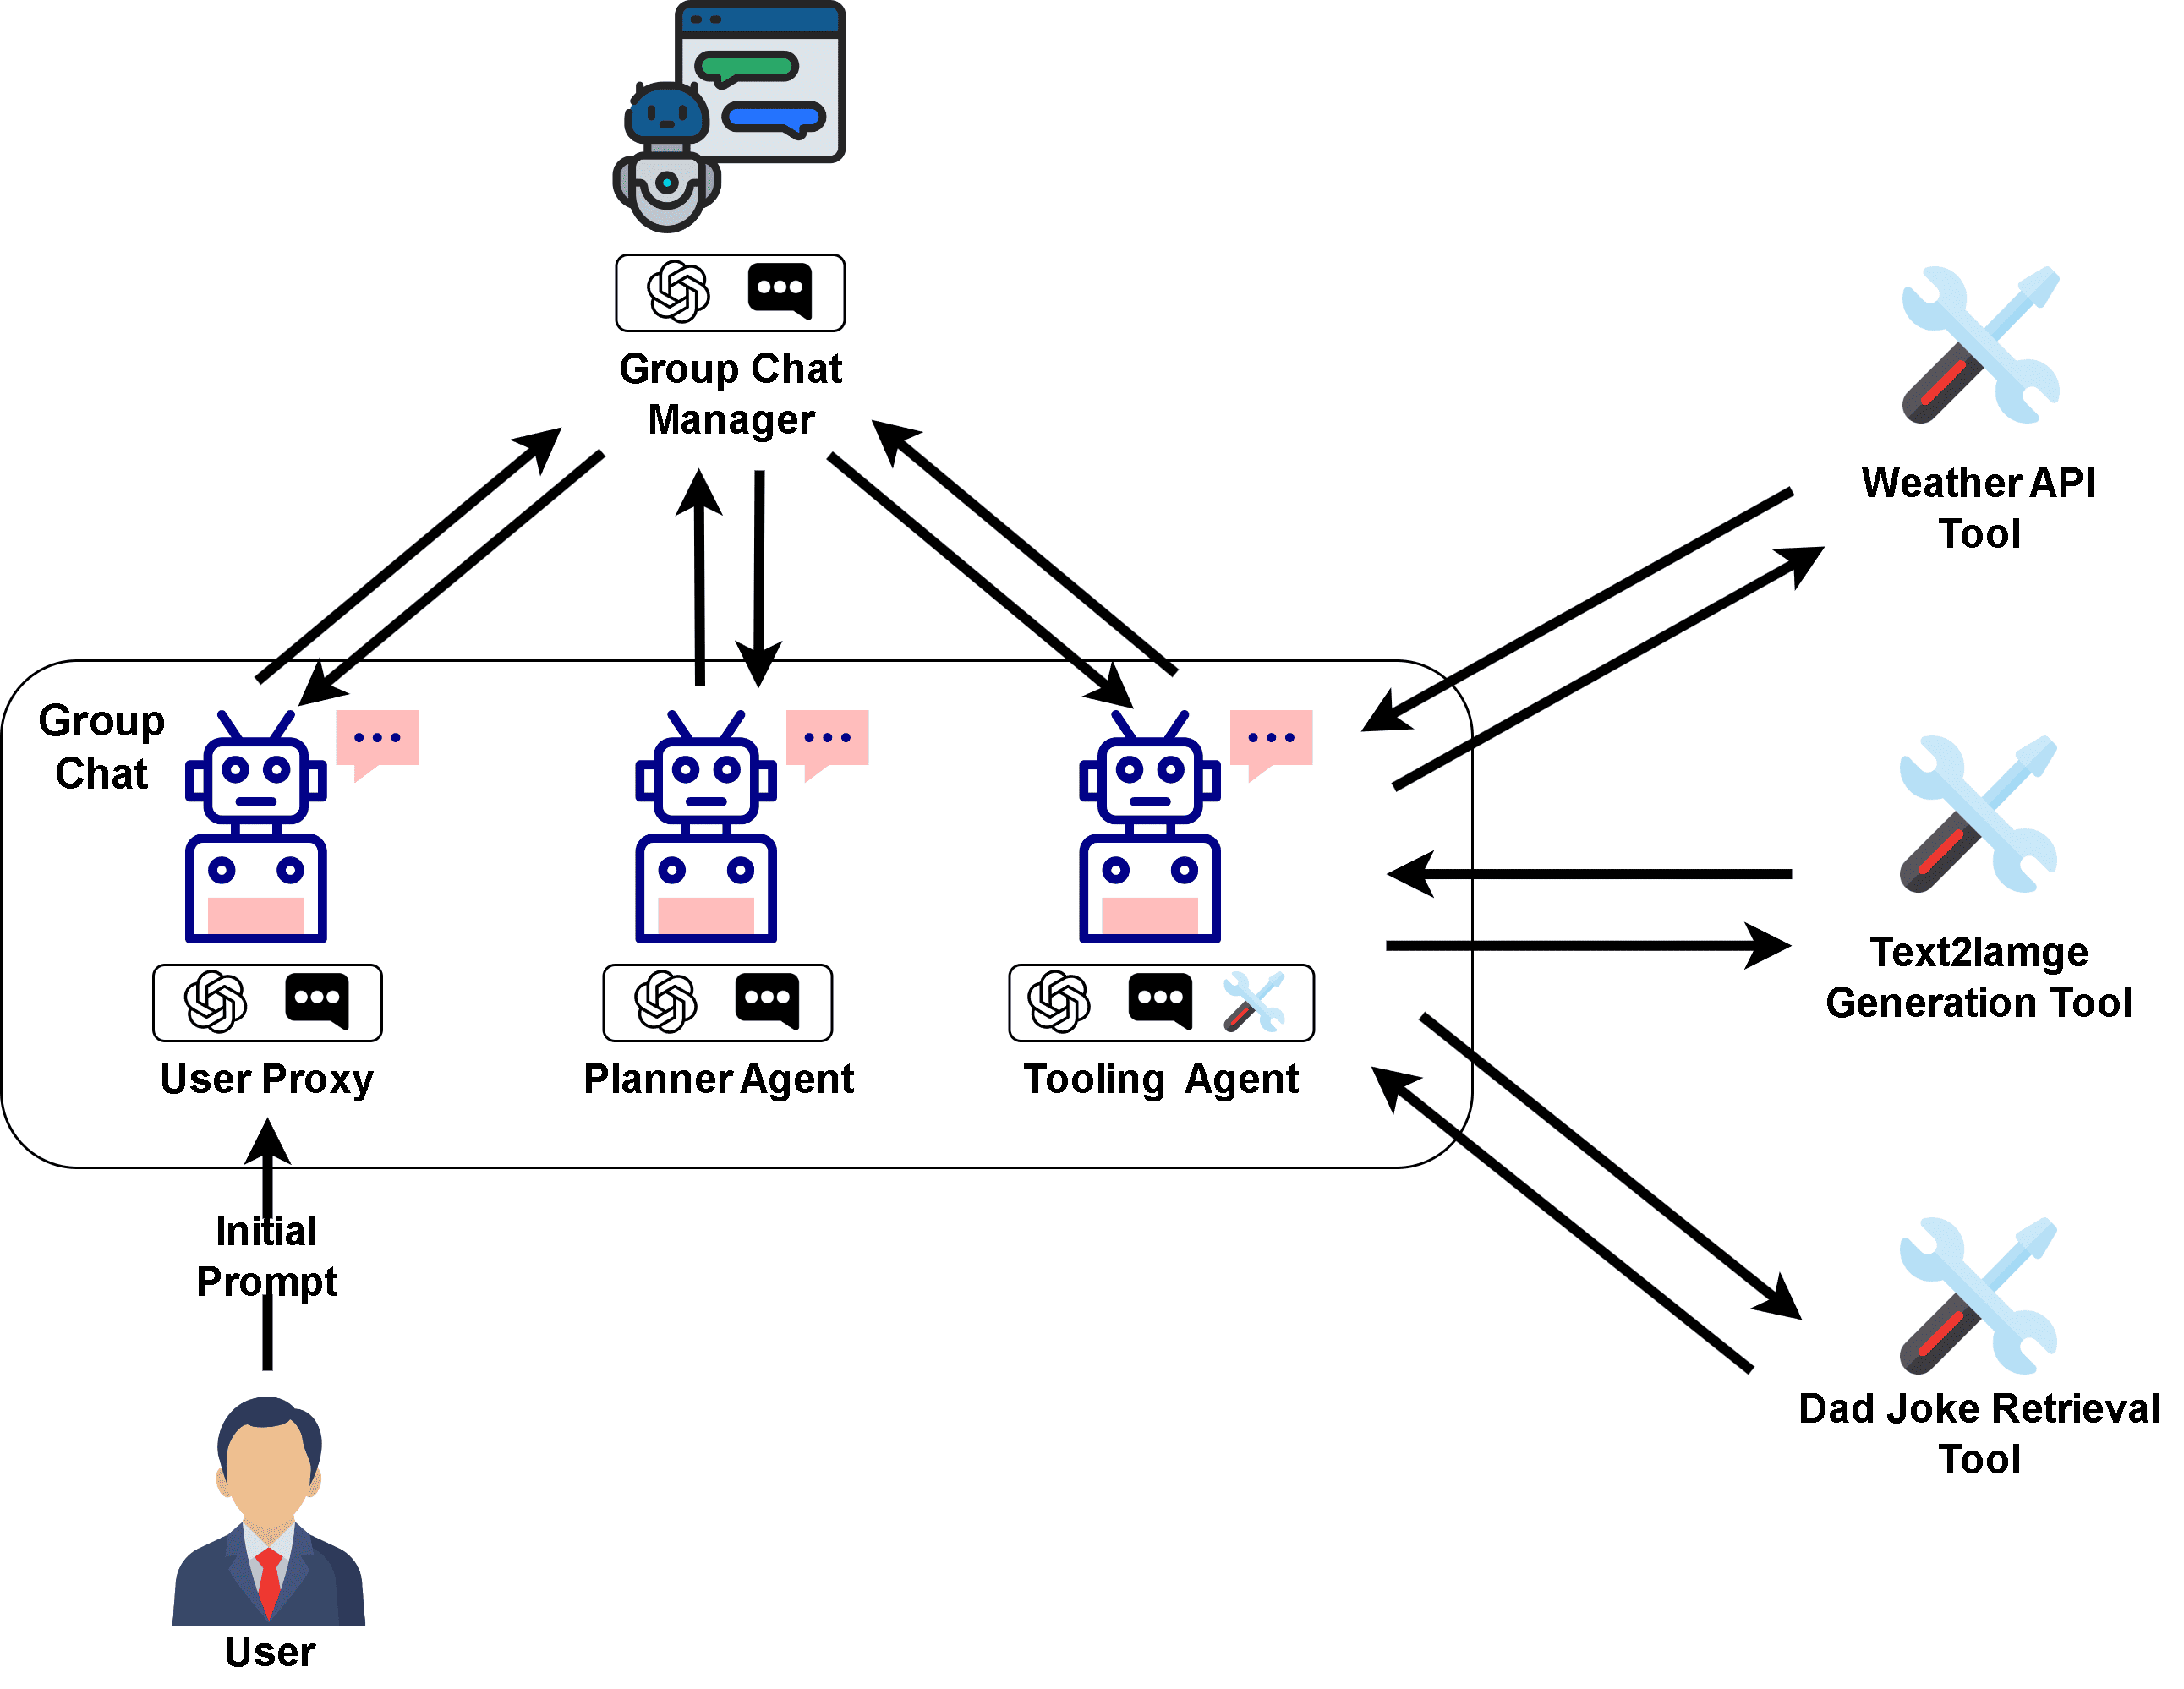

### Agent Loop in the Autogen Example
In the second example using the Autogen framework, the agent loop involves multiple agents working together to solve user queries. The loop includes the following steps:

1. **User Query**: The user provides a query through the UserProxyAgent.
2. **Planning**: The Planner agent receives the query and determines the necessary actions and tools to use.
3. **Tool Execution**: The ToolAgent executes the required tools based on the Planner's instructions.
4. **Result Handling**: The Planner agent processes the results from the ToolAgent and decides the next steps.
5. **User Response**: The Planner agent provides the final answer to the UserProxyAgent, which then communicates it to the user.

This loop continues until the query is fully resolved, and the UserProxyAgent terminates the conversation.

In [ ]:
# It takes around 5 mins
pipeline = AutoPipelineForText2Image.from_pretrained("warp-ai/wuerstchen", torch_dtype=torch.float16).to("cuda")

model_index.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/5.38k [00:00<?, ?B/s]

decoder/config.json:   0%|          | 0.00/525 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.41G [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/621 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/4.22G [00:00<?, ?B/s]

vqgan/config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

tokenizer/tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/73.6M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

model_index.json:   0%|          | 0.00/420 [00:00<?, ?B/s]

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

prior/config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/618 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.77G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.97G [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
nominatim = Nominatim()

In [ ]:
non_space_units = ['°', '%', '°C']

In [ ]:
def weather_api(city_name: str) -> dict:
  """
  Fetches the current weather data for a given city using the Open-Meteo API and Nominatim geocoding service.
  Args:
    city_name (str): The name of the city for which to fetch the weather data.
  Returns:
    dict: A dictionary containing the current weather data. The dictionary includes:
      - 'status' (str): 'success' if the data was fetched successfully, 'error' otherwise.
      - 'description' (str, optional): Error description if the city was not found.
      - Other keys representing weather parameters such as temperature, humidity, wind speed, etc., with their respective units.
  """

  # Nominatim API
  # The Nominatim API is used for geocoding and reverse geocoding.
  # It requires a location name as input and returns detailed information about the location, including latitude and longitude coordinates.
  data = nominatim.query(city_name)

  result = {}
  if data._json:
      latitude = data.toJSON()[0]['lat']
      longitude = data.toJSON()[0]['lon']

      # Open-Meteo API
      # The Open-Meteo API provides weather forecast data for a given location based on latitude and longitude coordinates.
      # It can provide multiple information such as temperature, humidity, wind speed, precipitation, etc.
      url = f"https://api.open-meteo.com/v1/forecast?latitude={latitude}&longitude={longitude}&current=temperature_2m,relative_humidity_2m,apparent_temperature,is_day,precipitation,rain,cloud_cover,pressure_msl,surface_pressure,wind_speed_10m,wind_direction_10m"

      response = requests.get(url)
      forecast_data = response.json()
      current_units = forecast_data['current_units']
      current_weather = forecast_data['current']

      keys = current_units.keys()
      result['status'] = 'success'
      for key in keys:
        result[key] = f'{current_weather[key]} {current_units[key]}'
        if current_units[key] in non_space_units:
          result[key] = f'{current_weather[key]}{current_units[key]}'
        if key == 'is_day':
            result[key] = 'Day' if current_weather[key] == 1 else 'Night'
        if key == 'time':
          result[key] = current_weather[key]
      return result

  else:
    result['status'] = 'error'
    result['description'] = 'City not found'
    return result


In [ ]:
def dad_joke_retriever(term: str = "") -> dict:
  """
  Retrieves a random dad joke from the icanhazdadjoke API. If a search term is provided, it retrieves a random joke from the search results.
  Args:
    term (str): The search term to look for in dad jokes. Defaults to an empty string, which retrieves a random joke.
  Returns:
    dict: A dictionary containing the status and the joke. If a joke is found, the dictionary contains:
      - 'status': 'success'
      - 'joke': The text of the joke.
    If no jokes are found, the dictionary contains:
      - 'status': 'error'
      - 'description': 'No jokes found'
"""
  is_term_search = f'search?term={term}' if term else ''

  url = f"https://icanhazdadjoke.com/{is_term_search}"

  headers = {
    "Accept": "application/json"
  }
  response = requests.get(url, headers=headers)

  jokes = response.json()['results'] if term else [response.json()]
  max_index = len(jokes)
  random_index = random.randint(0, max_index - 1)
  joke = jokes[random_index]
  result = {}
  if jokes:
    result['status'] = 'success'
    result['joke'] = joke['joke']
  else:
    result['status'] = 'error'
    result['description'] = 'No jokes found'
  return result

In [ ]:
def generate_image_prompt(text):
  """ Generates an image generation prompt based on the provided text.
  This function constructs a detailed prompt for generating an image,
  starting with a style and format, followed by a description, and
  concluding with a set of keywords. The prompt is descriptive and
  not imperative.
  Args:
    text (str): The input text based on which the image generation
          prompt will be created.
  Returns:
    str: The generated image prompt.
  """
  image_generation_prompt = f"""
Following the instruction generate an image generation prompt.
Start the description with a style (realistic, fantasy, comic, etc.) and format (oil painting, digital art, f1.8 photograph, etc.) information.
Then add short full description.
Conclude with a short set of keywords to emphasize.
The prompt should not be an imperative instruction, rather it should be descriptive.

Answer with the prompt only! Do not add any additional text.

Example:
Generate an image of a black cat riding a tiger in a storm, make it whimsical and add a carrot to the picture.

Fantasy digital art of a black cat riding a cartoony happy tiger with a storm raging in the background. The cat has a carrot sword in its paws. Storm, thunders, roar, black cat, carrot sword, riding.
"""

  msgs = [ChatMessage(role="system", content=image_generation_prompt),
          ChatMessage(role="user", content=text)]

  resp = llm.chat(
      model="gpt-4o-mini",
      temperature=0.7,
      messages=msgs
  )
  return resp.message.content

In [ ]:
def text2image_generator(text: str) -> dict:
  """
  Generates an image based on the provided text description using a pre-trained text-to-image model.

  Args:
    text (str): The text description to generate the image from.

  Returns:
    dict: A dictionary containing the status and the path to the generated image. The dictionary includes:
      - 'state' (str): 'success' if the image was generated successfully, 'error' otherwise.
      - 'image_path' (str, optional): The absolute path to the generated image file if the image was generated successfully.
      - 'description' (str, optional): Error description if the image generation failed.
  """

  # Text2Image Tool
  # The Text2Image tool uses a pre-trained model to generate images from text descriptions.
  # It requires a text prompt as input and returns an image generated based on the description.
  result = {}
  try:

    images = pipeline(
      generate_image_prompt(text),
      height=1024,
      width=1536,
      prior_timesteps=DEFAULT_STAGE_C_TIMESTEPS,
      negative_prompt="low quality, ugly, deformed",
      prior_guidance_scale=4.0,
      num_images_per_prompt=1,
    ).images
    display(images[0])
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S_%f")
    filename = f"image_{timestamp}.png"

    result_image = images[0]
    result_image.save(filename)

    absolute_path = os.path.abspath(filename)
    result['state'] = 'succes'
    result['image_path'] = absolute_path
  except Exception as e:
    result['state'] = 'error'
    result['description'] = str(e)

  return result

In [ ]:
tools = {
    "weather_api": {
        "name": "weather_api",
        "task": "From the user query select the city_name and provide it to the tool agent in a JSON format.",
        "arguments": {
            "city_name": "the name of the city we are courious about"
            },
        "example": {
            "query": "What is the weather in Berlin?",
            "JSON_for_tooling_Agent": {
                "city_name": "Berlin"
            }
        }
    },
    "dad_joke_retriever": {
        "name": "dad_joke_retriever",
        "task": "From the user query select the term and provide it to the tool agent in a JSON format. If is no term requested then provide empty string",
        "arguments": {
            "term": "the term the user want to search, could be empty"
            },
        "example": {
            "query": "Tell me a joke",
            "JSON_for_tooling_Agent": {
                "term": ""
            }
        }
    },
    "text2image_generator": {
        "name": "text2image_generator",
        "task": "Provide the user query to the tooling agent in a JSON format. See example below.",
        "arguments": {
            "text": "the text which will be used in the text2image process"
        },
        "example": {
            "query": "Make me an image from a firefighter cat holding a car tire in its hands in sci-fi theme",
            "JSON_for_tooling_Agent": {
                "text": """Make me an image from a firefighter cat holding a car tire in its hands in sci-fi theme"""
            }
        }

    }
}

In [ ]:
tool_agent_prompt = f"""
  Your task is to call the suggested tool.
  You can use the follwoing tools:
  {json.dumps(tools)}

  Tool answers could be JSON reponses like the following:
  {{
    'status': 'succes',
    'time': 'some time'
  }}
  {{
    'status': 'error',
    'description': 'some error'
  }}

  Extract the answer from the JSON and answer the user.
 Return TERMINATE when you finished.
"""

planner_prompt = f"""
  You are an autonomous agent who has to solve problems the user provides.
  Reason how to solve the user's query using only the tools provided.
  Always provide one action to the ToolAgent, wait for the response, check the
  results provided and send the next action. After actions were done, provide an answer.
  If the tool ToolAGent asks for clarification, ask the user about addtional information
  then replan the actions and use the tools.

  If there is no more action needed, provide the output to the User_proxy.
  If the User_proxy does not need any more help, return TERMINATE message to the User_proxy.

  You can use the follwoing tools:
  {json.dumps(tools)}

  Tool answers could be JSON reponses like the following:
  {{
    'status': 'succes',
    'time': 'some time'
  }}
  {{
    'status': 'error',
    'description': 'some error'
  }}

  Provide JSON to TOOL Agent:
  {{
    'term':'cat'
  }}

  When you are finished, provide the wole reasoning process with the intermediate results.
  Return TERMINATE when you finished.
  """

## [Converasble Agent](https://microsoft.github.io/autogen/0.2/docs/reference/agentchat/conversable_agent#conversableagent)
It is a specialized agent designed to handle dynamic conversations by interacting with multiple tools and other agents. It supports messaging-based communication, enabling it to converse, send commands, and process responses autonomously within an AI-driven workflow.

## [UserProxyAgent](https://microsoft.github.io/autogen/0.2/docs/reference/agentchat/user_proxy_agent#userproxyagent)

Acts as an intermediary between a human user and the system, simulating user behavior and interactions. It is designed to receive user input, relay it to other agents or tools, and return the responses, facilitating a seamless communication flow between the user and the system.

Every Agent has a parameter called human_input_mode which controls when the agent prompts for human input during a conversation. It has three modes:

- **ALWAYS**: The agent requests human input for every message it receives, allowing continuous human intervention or feedback.

- **TERMINATE**: Human input is only requested when a termination condition is met, such as a specific message being received or after a set number of auto-replies.

- **NEVER**: The agent never asks for human input, making the conversation fully autonomous, unless a termination condition is reached​

More info on the Autogen [Human in the loop](https://microsoft.github.io/autogen/0.2/docs/tutorial/human-in-the-loop) page

In [ ]:
tool_agent = ConversableAgent(
    name="tool_agent",
    system_message=tool_agent_prompt,
    llm_config={"config_list": [{"model": "gpt-4o-mini", "api_key": os.environ["OPENAI_API_KEY"]}]},

)

planner = ConversableAgent(
    name="planner",
    llm_config={"config_list": [{"model": "gpt-4o-mini", "api_key": os.environ["OPENAI_API_KEY"]}]},
    human_input_mode="NEVER",
    system_message=planner_prompt,
)

user_proxy =  UserProxyAgent(
    name="user",
    system_message="""Human Admin. Always the first in conversation, it provides the questions""",
    llm_config=False,
    human_input_mode="ALWAYS",
    is_termination_msg=lambda x: x.get("content", "").rstrip().endswith("TERMINATE"),
    max_consecutive_auto_reply=1,
)




In [ ]:
register_function(
    weather_api,
    caller=planner,
    executor=tool_agent,
    name="weather_api",
    description="Weather API to get actual weather data for a city got as an argument",
)

register_function(
    dad_joke_retriever,
    caller=planner,
    executor=tool_agent,
    name="dad_joke_retriever",
    description="Dad joke retriever to get a random dad joke. If user specify term add term as argument, else provide empty string",
)

register_function(
    text2image_generator,
    caller=planner,
    executor=tool_agent,
    name="text2image_generator",
    description="Generetaes images from texts using ai model, it gets the textual description.",
)



In [ ]:
allowed_transitions = {
    tool_agent: [planner],
    planner: [tool_agent, user_proxy],
    user_proxy: [planner]
}

### Making the GroupChat object and GroupChatManager

In [ ]:
group_chat = GroupChat(agents=[user_proxy, planner, tool_agent], max_round=12, messages=[], allowed_or_disallowed_speaker_transitions=allowed_transitions, speaker_transitions_type="allowed")
manager = GroupChatManager(groupchat=group_chat,
                           llm_config={"config_list": [{"model": "gpt-4o-mini", "api_key": os.environ["OPENAI_API_KEY"]}]})

### You can query our "Framework" and you can finish the conversation with ***exit*** or ***quit*** words.

>Create an image based on the current weather in Budapest. Portray the city as well. In the end tell me a dad joke!
user (to chat_manager):

Create an image based on the current weather in Budapest. Portray the city as well. In the end tell me a dad joke!

--------------------------------------------------------------------------------

Next speaker: planner

planner (to chat_manager):

***** Suggested tool call (call_FJz0AgkPPeJJmffLtL1fXkH3): weather_api *****
Arguments: 
{"city_name":"Budapest"}
****************************************************************************

--------------------------------------------------------------------------------

Next speaker: tool_agent


>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION weather_api...


tool_agent (to chat_manager):

tool_agent (to chat_manager):

***** Response from calling tool (call_FJz0AgkPPeJJmffLtL1fXkH3) *****
{"status": "success", "time": "2024-11-10T15:45", "interval": "900 seconds", "temperature_2m": "6.0°C", "relative_humidity_2m": "63%", "apparent_temperature": "2.7°C", "is_day": "Night", "precipitation": "0.0 mm", "rain": "0.0 mm", "cloud_cover": "0%", "pressure_msl": "1028.9 hPa", "surface_pressure": "1010.2 hPa", "wind_speed_10m": "7.2 km/h", "wind_direction_10m": "85°"}
**********************************************************************

--------------------------------------------------------------------------------

Next speaker: planner

planner (to chat_manager):

***** Suggested tool call (call_l0zv3lYbYngEmRv4Z86UIHwU): text2image_generator *****
Arguments: 
{"text":"A night scene of Budapest with illuminated city landmarks, featuring a temperature of 6°C, clear skies and a gentle 7.2 km/h wind. The atmosphere should depict a serene winter eve

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

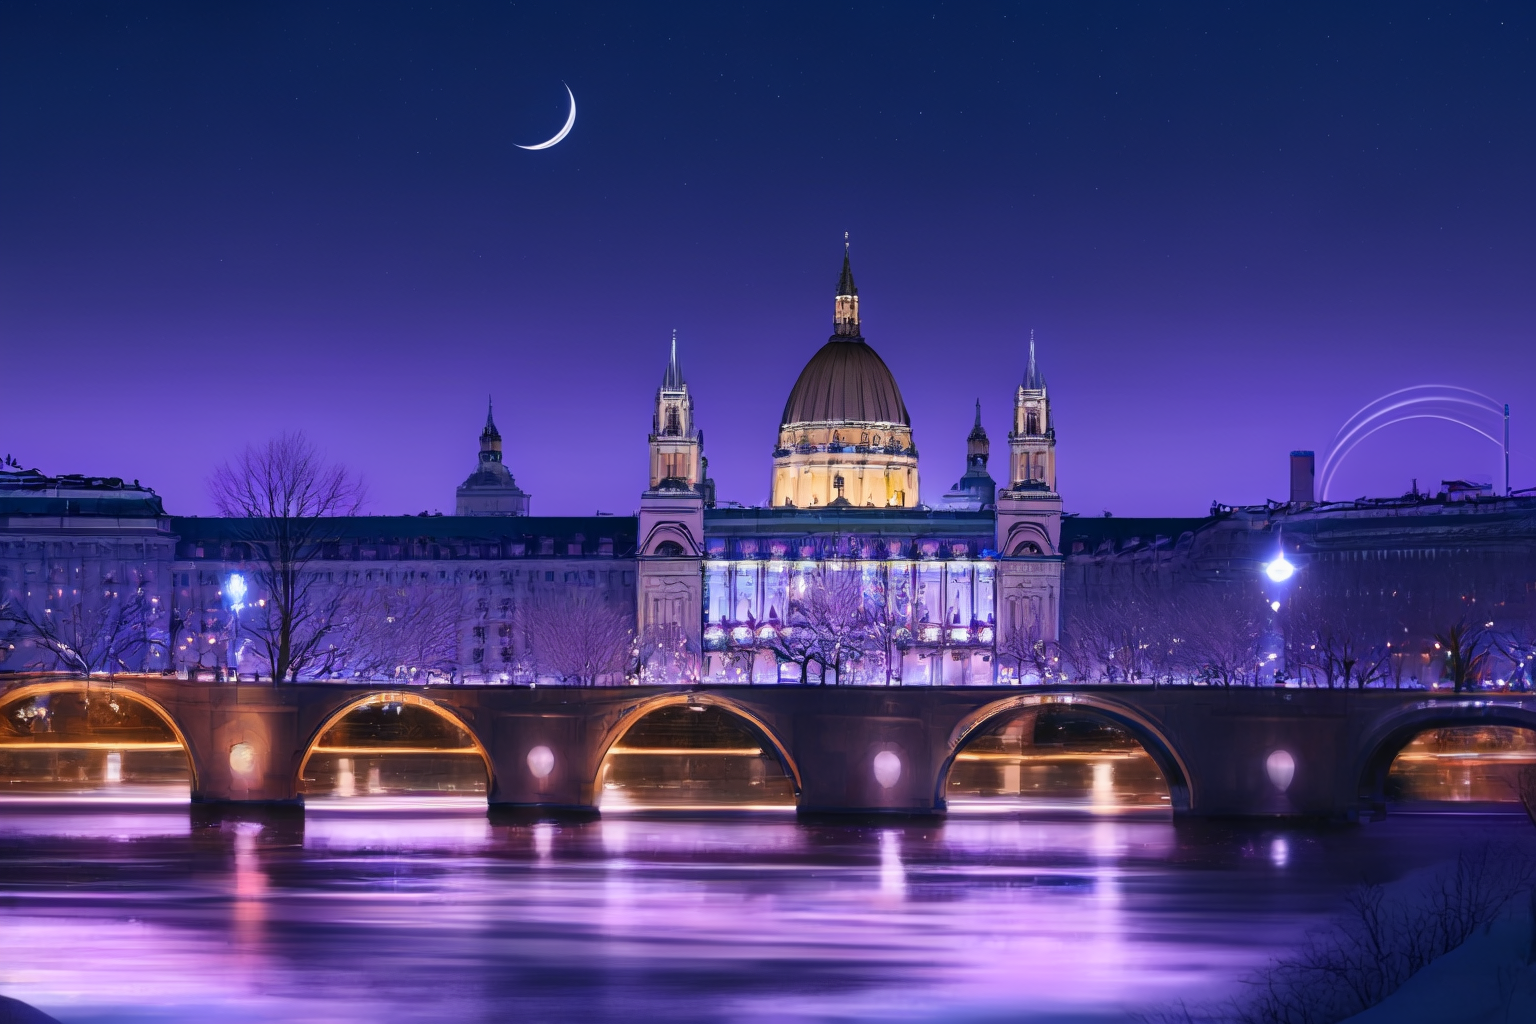

tool_agent (to chat_manager):

tool_agent (to chat_manager):

***** Response from calling tool (call_l0zv3lYbYngEmRv4Z86UIHwU) *****
{"state": "succes", "image_path": "/content/image_20241110_154820_250578.png"}
**********************************************************************

--------------------------------------------------------------------------------

Next speaker: planner

planner (to chat_manager):

***** Suggested tool call (call_gk3m6tjBA743OhGOc00Xj7XE): dad_joke_retriever *****
Arguments: 
{"term":""}
***********************************************************************************

--------------------------------------------------------------------------------

Next speaker: tool_agent


>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION dad_joke_retriever...
tool_agent (to chat_manager):

tool_agent (to chat_manager):

***** Response from calling tool (call_gk3m6tjBA743OhGOc00Xj7XE) *****
{"status": "success", "joke": "Slept like a log last night … woke up

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

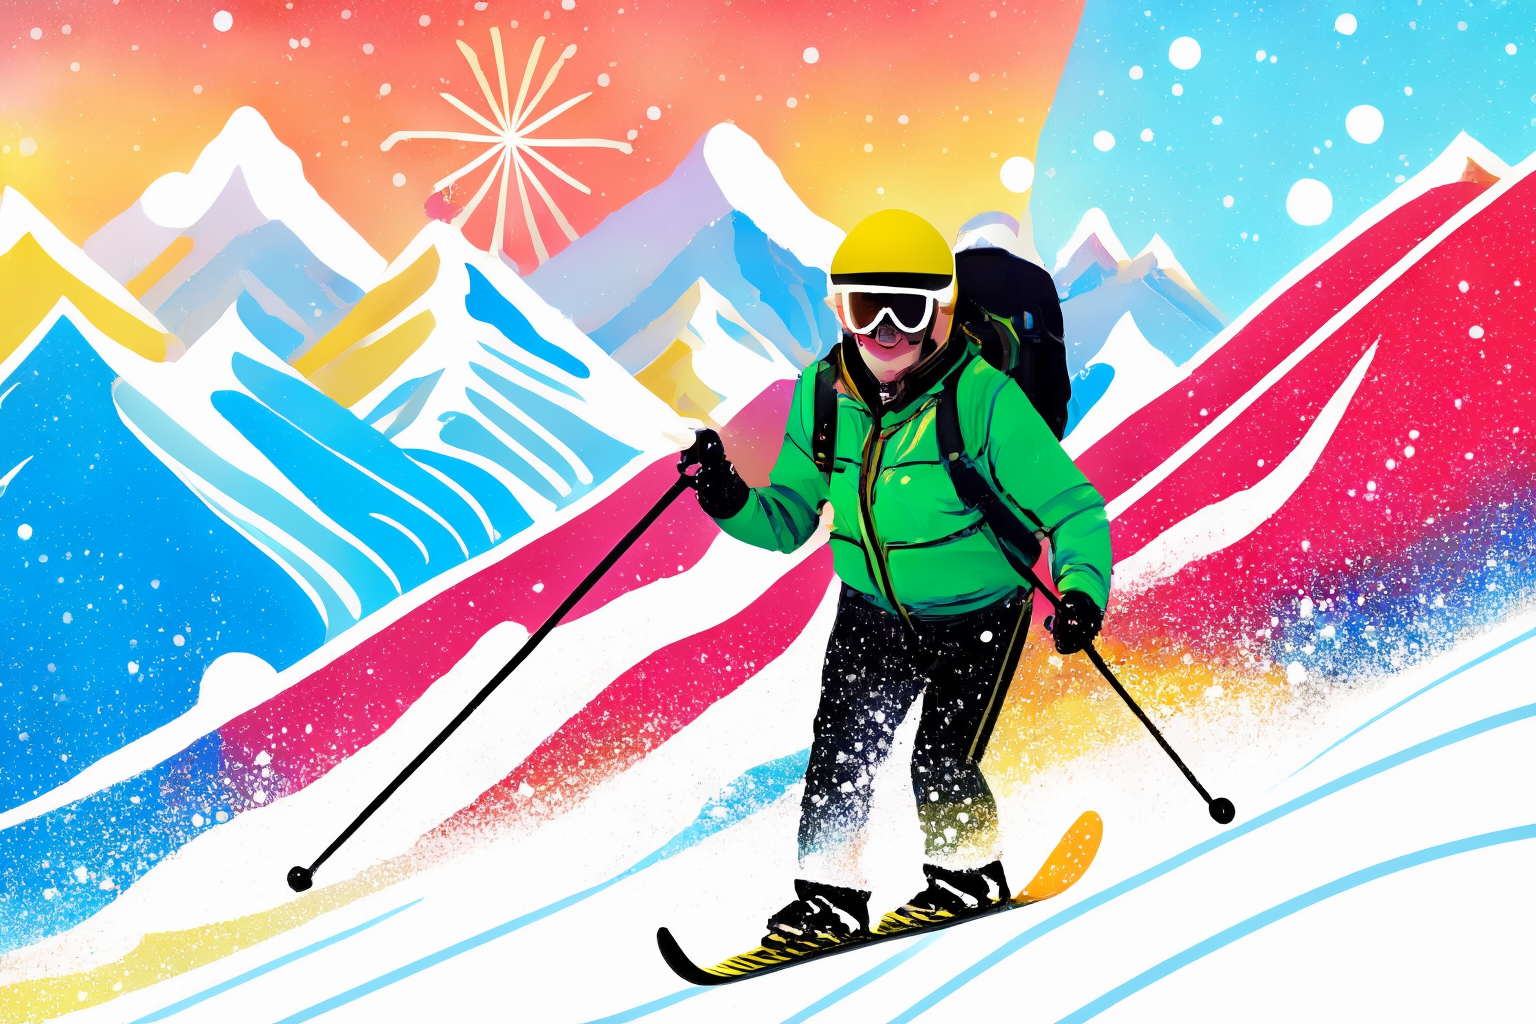

tool_agent (to chat_manager):

tool_agent (to chat_manager):

***** Response from calling tool (call_rXzKGm7x3yhz9HVBa7Ocvi5T) *****
{"state": "succes", "image_path": "/content/image_20241110_154952_842071.png"}
**********************************************************************

--------------------------------------------------------------------------------

Next speaker: planner

planner (to chat_manager):

I have generated an image of a skiing dog. Here it is:

![Skiing Dog](sandbox:/content/image_20241110_154952_842071.png)

If you have any other requests, feel free to ask! TERMINATE.

--------------------------------------------------------------------------------


ChatResult(chat_id=None, chat_history=[{'content': 'Create an image based on the current weather in Budapest. Portray the city as well. In the end tell me a dad joke!', 'role': 'assistant', 'name': 'user'}, {'content': '', 'tool_calls': [{'id': 'call_FJz0AgkPPeJJmffLtL1fXkH3', 'function': {'arguments': '{"city_name":"Budapest"}', 'name': 'weather_api'}, 'type': 'function'}], 'name': 'planner', 'role': 'assistant'}, {'content': '{"status": "success", "time": "2024-11-10T15:45", "interval": "900 seconds", "temperature_2m": "6.0°C", "relative_humidity_2m": "63%", "apparent_temperature": "2.7°C", "is_day": "Night", "precipitation": "0.0 mm", "rain": "0.0 mm", "cloud_cover": "0%", "pressure_msl": "1028.9 hPa", "surface_pressure": "1010.2 hPa", "wind_speed_10m": "7.2 km/h", "wind_direction_10m": "85°"}', 'tool_responses': [{'tool_call_id': 'call_FJz0AgkPPeJJmffLtL1fXkH3', 'role': 'tool', 'content': '{"status": "success", "time": "2024-11-10T15:45", "interval": "900 seconds", "temperature_2m"

In [ ]:
user_proxy.initiate_chat(manager)